# Softmax回归介绍

我们知道MNIST 数据集的每一张图片都表示一个(0 到9 的) 数字．那么，如果模
型若能看到一张图就能知道它属于各个数字的对应概率就好了。比如，我们的模型可能
看到一张数字"9" 的图片，就判断出它是数字"9" 的概率为80%，而有5% 的概率属于数
字"8"（因为8 和9 都有上半部分的小圆），同时给予其他数字对应的小概率（因为该图
像代表它们的可能性微乎其微）．

这是能够体现softmax 回归自然简约的一个典型案例．softmax 模型可以用来给
不同的对象分配概率．在后文，我们训练更加复杂的模型时，最后一步也往往需要用
softmax 来分配概率．

# 鸢尾花数据集

前面已经简单介绍过了鸢尾花数据集，这一节让我们用softmax分类器来试试将它们分类！

In [1]:
import sklearn
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

In [2]:
data = sklearn.datasets.load_iris()['data']
target = sklearn.datasets.load_iris()['target']

columns = sklearn.datasets.load_iris()['feature_names']
target_names = sklearn.datasets.load_iris()['target_names']
iris =    pd.concat([pd.DataFrame(data,columns=columns),
          pd.DataFrame([[i,target_names[i]] for i in target],columns=['target','target_label'])],
          axis=1)
#虚拟变量的one_hot编码
iris = pd.get_dummies(iris,columns=['target'])

In [3]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(iris[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)']].values,iris[['target_0', 'target_1', 'target_2']].values,test_size=0.3)

In [4]:
import tensorflow as tf
from tensorflow.contrib import slim

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,4])
y_placeholder = tf.placeholder(tf.float32,shape=[None,3])
with tf.variable_scope('network'):
    logits = slim.fully_connected(x_placeholder,3,
                                  biases_initializer=tf.random_normal_initializer,
                                  weights_initializer=tf.random_normal_initializer,
                                  activation_fn=None)
    y_predict = tf.nn.softmax(logits)
print(logits)
loss = slim.losses.softmax_cross_entropy(logits,y_placeholder)
train = slim.train.AdamOptimizer().minimize(loss,var_list=tf.get_collection('trainable_variables',scope='network'))
correct_prediction = tf.equal(tf.argmax(y_predict,1),tf.argmax(y_placeholder,1))
correct_prediction = tf.cast(correct_prediction,'float32')
accurrency = tf.reduce_mean(correct_prediction)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        if i%1000 ==0:
            _loss_train = sess.run(loss,feed_dict={x_placeholder:x_train,y_placeholder:y_train})
            _loss_test,_accurrency = sess.run([loss,accurrency],feed_dict={x_placeholder:x_test,y_placeholder:y_test})
            print(_loss_train,_loss_test,_accurrency)
        sess.run(train,feed_dict={x_placeholder:x_train,y_placeholder:y_train})
    # 查看各个变量的权重
    w = sess.run(tf.get_collection('trainable_variables',scope='network'),
            feed_dict={x_placeholder:x_test,y_placeholder:y_test})

Tensor("network/fully_connected/BiasAdd:0", shape=(?, 3), dtype=float32)
5.0953555 4.7522497 0.35555556
0.969433 1.0228369 0.5555556
0.59505606 0.62680805 0.62222224
0.43157244 0.44442746 0.8666667
0.31595135 0.31595886 1.0
0.23368332 0.22667868 1.0
0.1772938 0.16663915 1.0
0.13897245 0.12604564 1.0
0.11277349 0.098031655 1.0
0.09467914 0.078323245 1.0


In [6]:
tf.GraphKeys.TRAINABLE_VARIABLES

'trainable_variables'

In [7]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[]

# MNIST手写数据集识别

MNIST是一份手写数据集，数据集可被分为三部分：55000 行训练用点数据集（mnist.train），10000行测试数据集(mnist.test)，以及5000 行验证数据集（mnist.validation）．这样的切分很重要：在机器学习模型设计时必须有一个单独的测试数据集不用于训练而是用来评估这个模型的性能，从而更加容易把设计的模型推广到其他数据集上（泛化）．

我们可以通过tensorflow.example.tutorials.mnist轻松的加载它

In [9]:
import tensorflow as tf
from tensorflow.contrib import slim

from tensorflow.examples.tutorials.mnist import input_data
# 这里one_hot的含义是one hot编码，即用n个单元对n个状态编码，
# 以mnist数据集为例，0,1,2,3,4,5,6,7,8,9这10种数字将分别被编码为：
# 0 = [1,0,0,0,0,0,0,0,0,0]
# 1 = [0,1,0,0,0,0,0,0,0,0]
# ...
# 9 = [0,0,0,0,0,0,0,0,0,1]
mnist = input_data.read_data_sets('data/MNIST_data/',one_hot=True)

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


mnist 数据集中的每一张图片被存储成了一个784维的数组

In [11]:
x_train[0].shape,x_train[0]

((784,), array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.      

可以将它绘制出来：

In [13]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

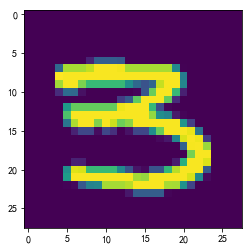

In [15]:
plt.imshow(x_train[0].reshape([28,28]))

## 开始回归
这一节我们非常粗暴的忽略图像相邻像素之间的关联，把28\*28的图像进行展开，得到一个784维的向量，然后把这个向量当成输入，并且不使用隐藏层，直接将输入层和输出层运用softmax分类器进行连接，得到预测的输出。

In [8]:
tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32,shape=[None,784])
y_placeholder = tf.placeholder(tf.float32,shape=[None,10])
# model
with tf.variable_scope('network'):
    logits = slim.fully_connected(x_placeholder,
                                  10,
                                  activation_fn=None,
                                  weights_initializer=tf.zeros_initializer,
                                  biases_initializer=tf.zeros_initializer)
    y_p = tf.nn.softmax(logits)
loss = slim.losses.softmax_cross_entropy(logits,y_placeholder)
correct_prediction = tf.equal(tf.argmax(y_p,1),
                              tf.argmax(y_placeholder,1))
correct_prediction2 = tf.cast(correct_prediction,'float')
accurrency = tf.reduce_mean(correct_prediction2)
train = tf.train.GradientDescentOptimizer(0.01).minimize(loss,var_list=tf.get_collection('trainable_variables'))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        if i%1000==0:
            x_test,y_test = mnist.test.next_batch(500)
            _loss,_accurrency = sess.run([loss,accurrency],feed_dict={x_placeholder:x_test,y_placeholder:y_test})
            print(_loss,_accurrency)
            pass
        x_train,y_train = mnist.train.next_batch(100)
        sess.run(train,feed_dict={x_placeholder:x_train,y_placeholder:y_train})

2.3025827 0.102
0.5355226 0.892
0.48929983 0.89
0.4373034 0.874
0.35466945 0.9
0.3984976 0.902
0.3870199 0.892
0.37214842 0.906
0.28934312 0.92
0.32017913 0.914
